In [ ]:
!pip install langchain_community langgraph langchain langchain_groq langchain_huggingface faiss-cpu langchain-community wikipedia langchain_tavily  arxiv

In [ ]:
pip install -U ddgs

In [9]:
import os
from typing import List
from pydantic import BaseModel
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader,WebBaseLoader
from langgraph.graph import StateGraph, END

## LLM SetUP

In [ ]:
# Initialize Multimodal model

from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model
llm = init_chat_model("groq:meta-llama/llama-4-maverick-17b-128e-instruct")
llm.invoke("how are you").content

# llm = ChatGroq(
#     model="llama-3.3-70b-versatile",
#     temperature=0
#     # Free but rate limited
# )
llm.invoke("how are you").content

"I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you have! How are you doing today?"

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
import os

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",)

In [ ]:
# ----------------------------
# 1. Load and Embed Documents
# ----------------------------
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]
docs = []
for url in urls:
    docs.extend(WebBaseLoader(url).load())

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever()


## tools maintaning

In [ ]:
## Importing package
from langchain.messages import HumanMessage
from langchain_community.tools import ArxivQueryRun
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_tavily import TavilySearch
from langchain.tools import tool
from wikipedia import summary
import os
import re


/usr/local/lib/python3.12/dist-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
/usr/local/lib/python3.12/dist-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


In [12]:
## Wikipedia Search
@tool("wiki_search", description="Search from the wikipedia and return summary.")
def wiki_search(query: str):
    """
    Searches Wikipedia and returns the summary of the query.
    """
    try:
        return summary(query, sentences=5)
    except Exception as e:
        return str(e)

## DuckDUck Go search
DuckDuck_search= DuckDuckGoSearchRun()
DuckDuck_search.invoke("Obama's first name?")

## Tvily search
tavily_search = TavilySearch(
    max_results=5,
    topic="general",
)

#arxiv Search
@tool("arxiv_abstract", description="Search research papers from arXiv and return top abstracts.")
def ArxivAbstract(query: str):
    try:
        api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
        arxiv_runner = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
        results = arxiv_runner.invoke(query)
        return results
    except Exception as e:
        return f"Error fetching from arXiv: {e}"

In [13]:
## Blinding tools with llm
tools=[DuckDuck_search,tavily_search,ArxivAbstract,wiki_search]
llm_with_tools = llm.bind_tools(tools)

# TESTING

In [48]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition
from pydantic import BaseModel, Field
from typing import List, Dict, Any

class test(BaseModel):
    question: str
    final_answer: str = ""  # Add default empty string
    verified: bool = False
    attempts: int = 0
    sub_questions: List[str] = Field(default_factory=list)
    plan_steps: List[str] = Field(default_factory=list)
    tool_responses: List[Dict[str, Any]] = Field(default_factory=list)

## Query Decompostion

In [15]:
def decompose(state:test):

    prompt = f"""
    Break the question into 2-3 short sub-questions.
    Output only as a numbered list (1., 2., 3.).

    Question: {state.question}
    """
    result = llm.invoke(prompt).content
    sub_questions = re.findall(r'\d+\.\s+(.*)', result)

    # Update the existing state object
    state.sub_questions = sub_questions
    state.plan_steps = sub_questions
    return state

## Resoning Step

In [16]:
import json

def PlanningStep(state:test):

    prompt = f"""
    You are an AI assistant. Solve the following question step by step.
    Generate 5 step MAX
    Output only as a numbered list (1., 2., 3.).

    Keep each step concise, focused, and actionable, showing the logical reasoning to understand or solve the question.

    Question: {state.question}
    """
    # Get LLM response as a string
    result = llm.invoke(prompt).content
    steps = re.findall(r'(\d+\..*?)(?=(?:\n\d+\.|$))', result, re.DOTALL)
    steps = [s.strip() for s in steps]

    # Update the existing state object
    state.plan_steps = steps
    return state

In [17]:
decompose(test(question="How does Agentic RAG works"))

test(question='How does Agentic RAG works', final_answer='', sub_questions=['What is Agentic RAG?', 'What are the key components of Agentic RAG?', "How do these components interact to enable Agentic RAG's functionality?"], plan_steps=['What is Agentic RAG?', 'What are the key components of Agentic RAG?', "How do these components interact to enable Agentic RAG's functionality?"], tool_responses=[])

In [18]:
PlanningStep(test(question="why IpBlocked exception happen"))

test(question='why IpBlocked exception happen', final_answer='', sub_questions=[], plan_steps=['1. The IpBlocked exception typically occurs when a server or a service blocks incoming requests from a specific IP address.', '2. This blocking usually happens due to excessive requests from the IP address within a short period, indicating potential malicious activity or abuse.', '3. IP blocking can also be triggered by violating the terms of service or acceptable use policy of the server or service.', '4. Another reason could be that the IP address has been previously identified as a source of spam, malware, or other types of cyber threats.', '5. The IpBlocked exception is a protective measure to prevent harm to the server, its users, or the services it provides.'], tool_responses=[])

## Tool Selector

In [19]:
from langgraph.prebuilt import ToolNode

# Define your actual tools
tools=[DuckDuck_search,tavily_search,ArxivAbstract,wiki_search]

# Create tool node that auto-executes
tool_node = ToolNode(tools)

def tool_select_sub_question(state: test):
    """Process sub-questions with automatic tool execution"""
    sub_questions = state.sub_questions
    all_results = []

    for sub_question in sub_questions:
        # LLM decides which tools to use
        response = llm_with_tools.invoke(sub_question)

        # If tools were called, execute them automatically
        if response.tool_calls:
            # This automatically runs the tools!
            tool_results = tool_node.invoke({"messages": [response]})

            all_results.append({
                "question": sub_question,
                "response": response,
                "tool_results": tool_results
            })
        else:
            all_results.append({
                "question": sub_question,
                "response": response
            })

    return {"tool_responses": all_results}

#Refining Ouput

In [53]:
## Reflect on answer
def reflect_on_answer(state: test) -> test:

    prompt = f"""
Evaluate whether the answer below is factually sufficient and complete.

Question: {state.question}
Answer: {state.final_answer}

Respond 'YES' if it's complete, otherwise 'NO' with feedback.
"""
    feedback = llm.invoke(prompt).content.lower()
    verified = "yes" in feedback
    state.verified = verified
    return state

In [54]:
## Refine query
def refine_query(state: test):
    sub_question_str = "\n".join(state.sub_questions)

    prompt = f"""
The answer appears incomplete. Suggest a better version of the 2-3 short sub-questions that would help retrieve more relevant context.
Output only as a numbered list (1., 2., 3.).

Original Question: {state.question}
Sub-Questions: {sub_question_str}
Current Answer: {state.final_answer}
"""
    result = llm.invoke(prompt).content
    sub_questions = re.findall(r'\d+\.\s+(.*)', result)

    # Update the existing state object
    state.sub_questions = sub_questions
    return state

In [55]:
from langchain.messages import AIMessage, HumanMessage
def aggregate_results(state: test):
    """
    Combine all tool responses into a final answer.
    """
    question = state.question
    tool_responses = state.tool_responses

    # Build context from all sub-question answers
    context = []
    for item in tool_responses:
        context.append(f"Q: {item['question']}")

        # Get the response content
        if isinstance(item['response'], AIMessage):
            context.append(f"A: {item['response'].content}")
        else:
            context.append(f"A: {item['response']}")

        # Add tool results if available
        if 'tool_results' in item and item['tool_results']:
            if 'messages' in item['tool_results']:
                for msg in item['tool_results']['messages']:
                    context.append(f"Additional info: {msg.content}")

    # Combine everything into a prompt
    combined_context = "\n\n".join(context)

    prompt = f"""Based on the following research:

{combined_context}

Now answer the original question comprehensively:
{question}

Provide a clear, detailed answer:"""

    # Generate final answer
    final_response = llm.invoke(prompt)
    state.attempts=state.attempts + 1

    return {"final_answer": final_response.content}

## WorkFlow

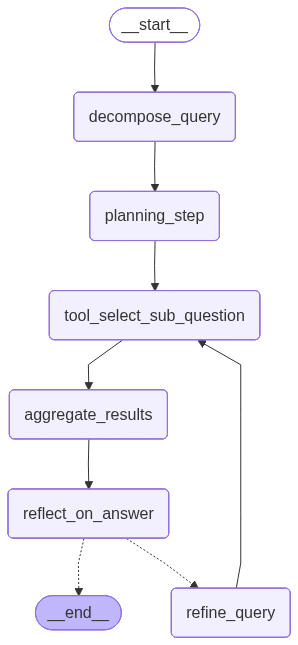

In [69]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(test)

# Add nodes
workflow.add_node("decompose_query", decompose)
workflow.add_node("planning_step", PlanningStep)
workflow.add_node("tool_select_sub_question", tool_select_sub_question)
workflow.add_node("reflect_on_answer", reflect_on_answer)
workflow.add_node("refine_query", refine_query)
workflow.add_node("aggregate_results", aggregate_results)

# Add edges
workflow.set_entry_point("decompose_query")
workflow.add_edge("decompose_query", "planning_step")
workflow.add_edge("planning_step", "tool_select_sub_question")
workflow.add_edge("tool_select_sub_question", "aggregate_results")
workflow.add_edge("aggregate_results", "reflect_on_answer")

# ⬇️ FIX THIS PART ⬇️
def decide_next(state):
    if state.verified or state.attempts >= 2:
        return END
    else:
        return "refine_query"

workflow.add_conditional_edges(
    "reflect_on_answer",
    decide_next,  # Use the function
    {
        END: END,              # Map string "end" to END
        "refine_query": "refine_query" # Map string "refine" to node
    }
)

workflow.add_edge("refine_query", "tool_select_sub_question")

w = workflow.compile()
w

In [66]:
query="How does Agentic RAG works"

In [73]:
result = w.invoke({"question":query})
print(result['final_answer'])

Agentic RAG is a sophisticated AI framework that combines the strengths of Retrieval-Augmented Generation (RAG) with the capabilities of AI agents to enhance the accuracy, adaptability, and scalability of information retrieval and generation tasks. To understand how Agentic RAG works, let's break down its key components and their interactions.

### Key Components of Agentic RAG

1. **AI Agents**: These are autonomous entities that play a crucial role in managing and optimizing the interaction between the retrieval system and the generation model. AI agents can be designed to perform various tasks, such as query planning, information retrieval, and response generation.

2. **Retrieval System**: This component is responsible for retrieving relevant information from a knowledge base or database. The retrieval system might use techniques such as keyword matching, semantic search, or dense passage retrieval.

3. **Generation Model**: This is typically a large language model (LLM) that gener